In [9]:
import os
import zipfile
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Downloading the data

In [10]:
TITANIC_ROOT = os.path.join("datasets", "titanic")
os.makedirs(TITANIC_ROOT, exist_ok=True)

!kaggle competitions download -c titanic -p {TITANIC_ROOT}

titanic_zip = os.path.join(TITANIC_ROOT, "titanic.zip")
with zipfile.ZipFile(titanic_zip, 'r') as zip_ref:
    zip_ref.extractall(TITANIC_ROOT)

os.remove(titanic_zip)

print(f"Files in directory: {os.listdir(TITANIC_ROOT)}")

Files in directory: ['gender_submission.csv', 'test.csv', 'train.csv']


# Preprocessing class

In [11]:
from abc import ABC, abstractmethod

class Preprocessing(ABC):
    def __init__(self, titanic_path=TITANIC_ROOT):
        train_csv_path = os.path.join(titanic_path, "train.csv")
        test_csv_path = os.path.join(titanic_path, "test.csv")
        self.train = pd.read_csv(train_csv_path)
        self.test = pd.read_csv(test_csv_path)
        self.numeric_columns_train = self.train.select_dtypes(include=['int64', 'float64'])
        self.categorical_columns_train = self.train.select_dtypes(exclude=['int64', 'float64'])
        self.numeric_columns_test = self.test.select_dtypes(include=['int64', 'float64'])
        self.categorical_columns_test = self.test.select_dtypes(exclude=['int64', 'float64'])
        self.deleting_columns()


    def deleting_columns(self):
        # Dropping the PassengerId and Name columns from train dataset and test dataset as well
        self.train.drop(columns=["PassengerId", "Name"], inplace=True)
        self.test.drop(columns=["PassengerId", "Name"], inplace=True)

        # Verifying if the PassengerId and Name columns from train and test datasets was dropped correctly
        columns_to_check = ["PassengerId", "Survived"]
        for col in columns_to_check:
            status = "was dropped  correctly" if col not in self.train.columns or col not in self.test.columns else "was not dropped"

    @abstractmethod
    def inconsistent_data(self):
        pass

    @abstractmethod
    def missing_data(self):
        pass


# Train Dataset

In [12]:
class TrainPreprocessing(Preprocessing):
    # Verifying inconsistent values
    def inconsistent_data(self):
        for column in self.numeric_columns_train.columns:
            inconsistent_values = self.train.loc[self.train[column] < 0]
            if inconsistent_values.empty:
                print(f"Column {column} has no inconsistent values")
            else:
                print(f"Column {column} has inconsistent values")

        return self.train

    # Verifying missing data
    def missing_data(self):
        print(self.train.isnull().sum())

        # Replacing the missing values in numerical columns with the mean
        self.train[self.numeric_columns_train.columns] = self.train[self.numeric_columns_train.columns].apply(lambda column: column.fillna(column.mean()))
        # Replacing the missing data in categorical columns as 'Unknown'
        self.train[self.categorical_columns_train.columns] = self.train[self.categorical_columns_train.columns].fillna("Unknown")

        return self.train

    def histogram_graphs(self):
        self.train.hist(bins=50, figsize=(20, 15))
        plt.show()

    def correlation_matrix(self):
        correlation_matrix = self.numeric_columns_train.corr()
        survived_correlation = correlation_matrix["Survived"].sort_values(ascending=False)
        print(survived_correlation)

        plt.figure(figsize = (10, 8))
        survived_correlation.plot(kind="bar", color="red")
        plt.xlabel('Features')
        plt.ylabel('Correlation')
        plt.show()


Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64


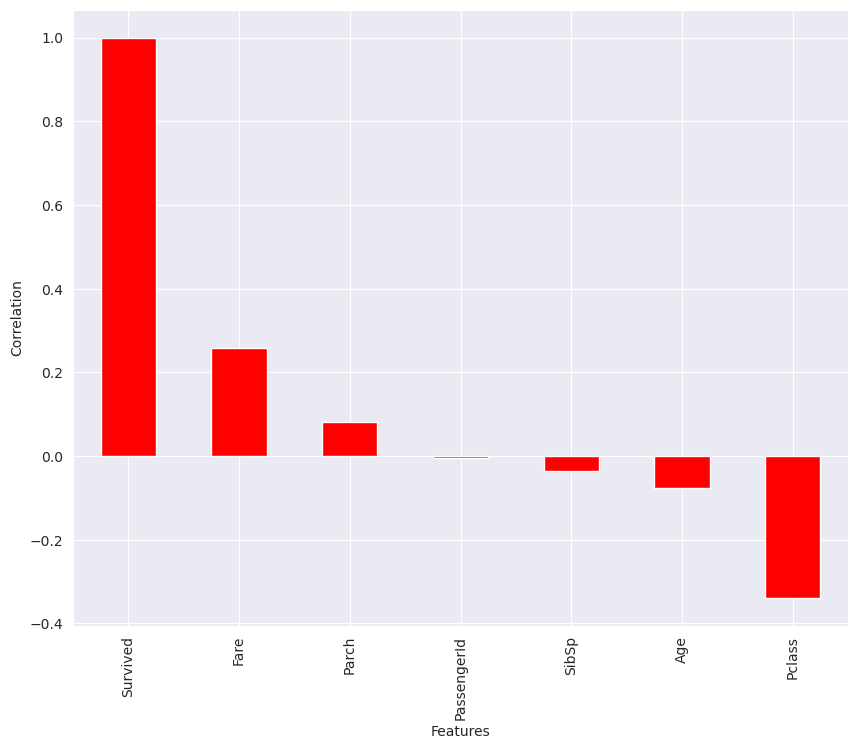

In [13]:
preprocessing = TrainPreprocessing()
preprocessing.train.head(10)
preprocessing.correlation_matrix()

# Test Dataset

In [14]:
class TestPreprocessing(Preprocessing):
    # Verifying inconsistent values
    def inconsistent_data(self):
        for column in self.numeric_columns_test.columns:
            inconsistent_values = self.test.loc[self.test[column] < 0]
            if inconsistent_values.empty:
                print(f"Column {column} has no inconsistent values")
            else:
                print(f"Column {column} has inconsistent values")

        return self.test

    # Verifying missing data
    def missing_data(self):
        print(self.test.isnull().sum())

        # Replacing the missing values in numerical columns with the mean
        self.test[self.numeric_columns_test.columns] = self.train[self.numeric_columns_test.columns].apply(lambda column: column.fillna(column.mean()))
        # Replacing the missing data in categorical columns as 'Unknown'
        self.test[self.categorical_columns_test.columns] = self.train[self.categorical_columns_test.columns].fillna("Unknown")

        return self.test


In [15]:
test_preprocessing = TestPreprocessing()
test_preprocessing.test.head(10)

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,male,34.5,0,0,330911,7.8292,NaN,Q
1,3,female,47.0,1,0,363272,7.0000,NaN,S
2,2,male,62.0,0,0,240276,9.6875,NaN,Q
3,3,male,27.0,0,0,315154,8.6625,NaN,S
4,3,female,22.0,1,1,3101298,12.2875,NaN,S
5,3,male,14.0,0,0,7538,9.2250,NaN,S
6,3,female,30.0,0,0,330972,7.6292,NaN,Q
7,2,male,26.0,1,1,248738,29.0000,NaN,S
8,3,female,18.0,0,0,2657,7.2292,NaN,C
9,3,male,21.0,2,0,A/4 48871,24.1500,NaN,S
